# import libs

In [1]:
import os
import numpy as np
import pandas as pd
import rasterio
import rasterio.mask
import rasterio.warp
import rasterio.features
import rasterio.plot
import rasterio.merge
import rasterio.enums
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import seaborn as sns
import geopandas as gpd
import pygris
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

### create the agreeance function

In [2]:
def agreeance(m1, m2):
    
    add = m1 + m2
    #print(add)
    ww = np.where(add > 1, 1, 0).sum()
    dd = np.where(add == 0, 1, 0).sum()
    
    sub = m1 - m2
    #print(sub)
    wd = np.where(sub == 1, 1, 0).sum()
    dw = np.where(sub == -1, 1, 0).sum()
    
    agr = ww / (ww + wd + dw)
    und = dw / (ww + wd + dw)
    ovr = wd / (ww + wd + dw)
    
    #print('agreeance =', np.round(agr * 100, 1), '%')
    #print('wet in 1 dry in 2 =', np.round(und * 100, 1), '%')
    #print('dry in 1 wet in 2 =', np.round(ovr * 100, 1), '%')
    
    out = [agr,und,ovr]
    
    return(out)

### get nc counties from pygris, start with wake county

Using the default year of 2021
Using FIPS code '37' for input 'NC'


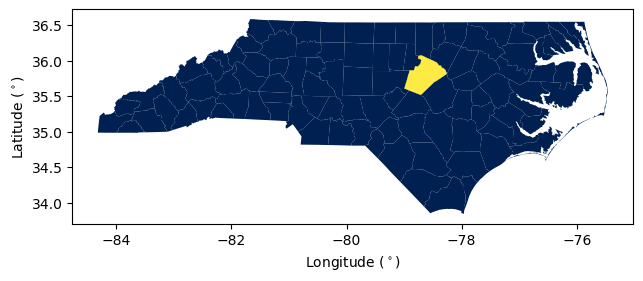

In [3]:
nccount = pygris.counties(state = 'NC', cb = True, cache = True)

fig, ax = plt.subplots()

nccount.plot(color = '#002051', ax = ax)
coi = nccount[nccount['NAME'] == 'Wake']
coi.plot(ax = ax, color = '#fdea45')
ax.set_xlabel('Longitude ($^\circ$)')
ax.set_ylabel('Latitude ($^\circ$)')
fig.tight_layout()

### read hand huc6 bounds and intersect with coi

These zip file download links contain all of the HAND files needed for this analysis

In [4]:
handhuc6 = gpd.read_file('hand_021/hand_021.shp')
for url in handhuc6.overlay(coi, how = 'intersection')['URL']:
    print(url)

https://cfim.ornl.gov/data/HAND/20200601/030202.zip
https://cfim.ornl.gov/data/HAND/20200601/030300.zip


### read in statewide fema flood map

This file was too large in it's raw form for the repository. Please uncompress it after download for this cell to work.

In [5]:
femafld = gpd.read_file('fema_nc.gpkg')

### read in hand.tif file

This file is too large to include in the repository. This is the merged HAND file from the two zipfiles shown in the cell above. I merged them using the **Merge Raster tool** in QGIS 3.28

In [6]:
hand = rasterio.open('nc_hand.tif')
handr = hand.read()
# rasterio.plot.show(np.where(handr < 0, np.nan, handr), transform=hand.transform)

### read in hand catchments

In [7]:
catchmaskgdf = gpd.read_file('nc_catchments.shp')

### intersect the catchments with the coi

<Axes: >

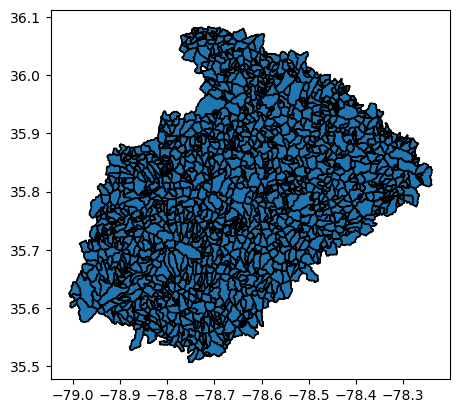

In [8]:
coicatchmask = gpd.clip(catchmaskgdf, coi)
coicatchmask = catchmaskgdf[catchmaskgdf.comid.isin(coicatchmask['comid'])]

fig, ax = plt.subplots()
coicatchmask.plot(ax = ax, edgecolor = 'k')

### read in the discharge node locations from FEMA

<Axes: >

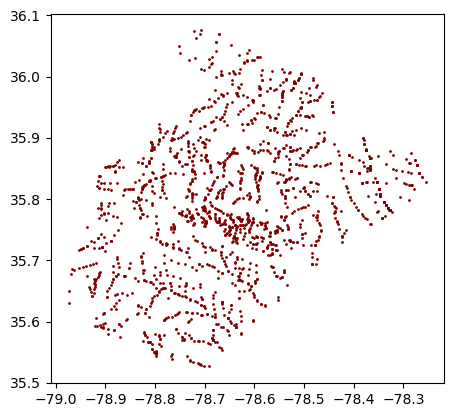

In [9]:
nodes = gpd.read_file('37183C_20230511/S_NODES.shp')
nodes = gpd.clip(nodes, coicatchmask)
nodes.plot(markersize = 1, color = 'maroon')

### read in the discharge summary from FEMA

In [10]:
disch = gpd.read_file('37183C_20230511/L_SUMMARY_DISCHARGES.dbf')
disch = disch[disch['EVENT_TYP'] == '1 Percent Chance']
disch = disch[disch['DISCH'] > 0]
disch['fema_disch_m3s'] = disch['DISCH']*0.028316847
disch = disch[['NODE_ID', 'fema_disch_m3s']]
disch.head()

,NODE_ID,fema_disch_m3s
7,37183C_371030201307188,31.743185
10,37183C_3710302013041684,29.449521
13,37183C_37103020130416115,26.334668
21,37183C_37103020130416114,33.130711
25,37183C_NU01420130207110,15.347731


### join the discharges to the nodes

In [11]:
disnodes = nodes.merge(disch, on = 'NODE_ID')
disnodes.head()

,DFIRM_ID,VERSION_ID,NODE_ID,NODE_TYP,WTR_NM,NODE_DESC,MODEL_ID,SOURCE_CIT,geometry,fema_disch_m3s
0,37183C,2.3.3.2,37183C_CF03020090205350,Sub-Basin Outlet,Neills Creek,"Approximately 1,060 feet upstream of Harnett/W...",Upper Cape Fear Tribs Hydrologic Report,37183C_STUDY112,POINT (-78.76633 35.53933),32.196255
1,37183C,2.3.3.2,37183C_CF03020090205341,Sub-Basin Outlet,Neills Creek,Approximately 0.6 mile upstream of Harnett/Wak...,Upper Cape Fear Tribs Hydrologic Report,37183C_STUDY112,POINT (-78.76751 35.54359),29.930907
2,37183C,2.3.3.2,37183C_CF03020090205560,Sub-Basin Outlet,"Kenneth Creek (Basin 24, Stream 2)",Approximately 0.45 mile downstream from the co...,Upper Cape Fear Tribs Hydrologic Report,37183C_STUDY112,POINT (-78.79847 35.54392),95.965794
3,37183C,2.3.3.2,37183C_3710702012050111807,Sub-Basin Outlet,"Kenneth Creek (Basin 24, Stream 2)",At Wake/Harnett County boundary,Moores Hood Hydrologic Report,37183C_STUDY112,POINT (-78.79789 35.54667),95.965794
4,37183C,2.3.3.2,37183C_CF03020090205286,Sub-Basin Outlet,Neills Creek,Approximately 0.9 mile upstream of Harnett/Wak...,Upper Cape Fear Tribs Hydrologic Report,37183C_STUDY112,POINT (-78.76681 35.54771),23.786151


### show the discharge nodes with the FEMA flood map for Wake County

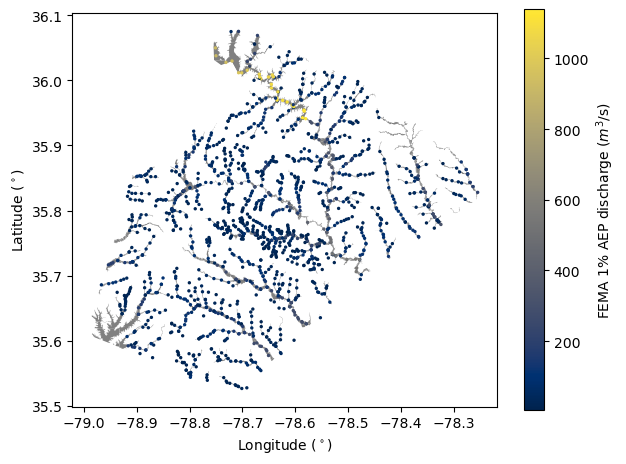

In [12]:
femawake = gpd.clip(femafld, coi)

fig, ax = plt.subplots()
# ax.set_title('Wake County FEMA discharge nodes')
# ax.set_axis_off()
femawake.plot(ax = ax,
              color = 'grey')
disnodes.plot(column = 'fema_disch_m3s', 
              ax = ax, 
              markersize = 2, 
              legend = True,
              legend_kwds={"label": "FEMA 1% AEP discharge ($m^3$/s)"},
              cmap = 'cividis')
ax.set_xlabel('Longitude ($^\circ$)')
ax.set_ylabel('Latitude ($^\circ$)')
fig.tight_layout()
# plt.rcParams['savefig.dpi']=450
# plt.savefig('fema_wake_disch.tif')

### spatially join the nodes to each HAND catchment

In [13]:
join = gpd.sjoin(left_df=coicatchmask, right_df=disnodes,  how="left", predicate="intersects")
join['fema_disch_m3s'] = np.where(np.isnan(join['fema_disch_m3s']), 0, join['fema_disch_m3s'])
join.head()

,comid,geometry,index_right,DFIRM_ID,VERSION_ID,NODE_ID,NODE_TYP,WTR_NM,NODE_DESC,MODEL_ID,SOURCE_CIT,fema_disch_m3s
38727,8783023,"POLYGON ((-78.37280 35.87711, -78.37261 35.877...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
38728,8782767,"POLYGON ((-78.38977 35.91672, -78.39010 35.916...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
38730,8783213,"MULTIPOLYGON (((-78.36616 35.85021, -78.36653 ...",1257.0,37183C,2.3.3.2,37183C_3710302013071863,Sub-Basin Outlet,"Basin 10, Stream 6","Hydrologic node located at 35.8481, -78.3681",Revised Effective Hydrology - Combination of e...,37183C_STUDY56,66.148155
38730,8783213,"MULTIPOLYGON (((-78.36616 35.85021, -78.36653 ...",1258.0,37183C,2.3.3.2,37183C_NU00920090330458,Sub-Basin Outlet,"Basin 10, Stream 6",At mouth,"Basin 10, Stream 9",37183C_STUDY115,40.209923
38730,8783213,"MULTIPOLYGON (((-78.36616 35.85021, -78.36653 ...",1360.0,37183C,2.3.3.2,37183C_NU00920090330206,Sub-Basin Outlet,Little River,"At confluence of Basin 10, Stream 6",Little River Subbasin Regression Analysis,37183C_STUDY115,276.089258


### calculate the average discharge for each HAND catchment

In [14]:
handflows = join[['comid','fema_disch_m3s']].groupby('comid').mean().reset_index()
handflows['src_a1'] = 0.0
handflows['src_a2'] = 0.0
handflows['src_b1'] = 0.0
handflows['src_b2'] = 0.0
handflows['maxstage_m'] = 0.0
handflows['src_R2_1'] = 0.0
handflows['src_R2_2'] = 0.0
handflows

,comid,fema_disch_m3s,src_a1,src_a2,src_b1,src_b2,maxstage_m,src_R2_1,src_R2_2
0,8777737,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8777753,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8777781,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8777783,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8777787,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1990,933020125,487.710495,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991,933020159,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,933020160,48.654007,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,933020163,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### read in the statewide SRC table

This file is too large to include in the respository. Refer to the "nc full optimization.ipynb" jupyter notebook and the related script called "src_combiner.py" to recreate this file for yourself.

In [15]:
src = pd.read_csv('nc_src.csv')
src

,Unnamed: 0,CatchId,Stage,Number of Cells,SurfaceArea (m2),BedArea (m2),Volume (m3),SLOPE,LENGTHKM,AREASQKM,Roughness,TopWidth (m),WettedPerimeter (m),WetArea (m2),HydraulicRadius (m),Discharge (m3s-1)
0,0,6267624,0.0000,84,7297.973795,7299.069933,0.000000e+00,0.001956,0.823,0.6381,0.05,8.867526,8.868858,0.000000,0.000000,0.000000
1,1,6267624,0.3048,121,10512.573299,10514.158786,2.642198e+03,0.001956,0.823,0.6381,0.05,12.773479,12.775406,3.210447,0.251299,1.130928
2,2,6267624,0.6096,160,13900.911377,13905.223123,6.334778e+03,0.001956,0.823,0.6381,0.05,16.890536,16.895775,7.697179,0.455568,4.031278
3,3,6267624,0.9144,184,15986.034295,15992.887235,1.088041e+04,0.001956,0.823,0.6381,0.05,19.424100,19.432427,13.220431,0.680328,9.046213
4,4,6267624,1.2192,209,18158.049951,18175.385837,1.610807e+04,0.001956,0.823,0.6381,0.05,22.063244,22.084308,19.572380,0.886257,15.974443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14795575,1177267,3357660,23.7744,3618,311311.186630,312323.654445,6.632602e+06,0.000000,1.452,0.3114,0.05,214.401644,215.098936,4567.907945,21.236311,0.000000
14795576,1177268,3357660,24.0792,3618,311311.186630,312323.654445,6.727490e+06,0.000000,1.452,0.3114,0.05,214.401644,215.098936,4633.257566,21.540123,0.000000
14795577,1177269,3357660,24.3840,3618,311311.186630,312323.654445,6.822378e+06,0.000000,1.452,0.3114,0.05,214.401644,215.098936,4698.607187,21.843935,0.000000
14795578,1177270,3357660,24.6888,3618,311311.186630,312323.654445,6.917265e+06,0.000000,1.452,0.3114,0.05,214.401644,215.098936,4763.956808,22.147747,0.000000


### plot stage discharge curves to see their shape

<Axes: xlabel='Discharge (m3s-1)', ylabel='Stage'>

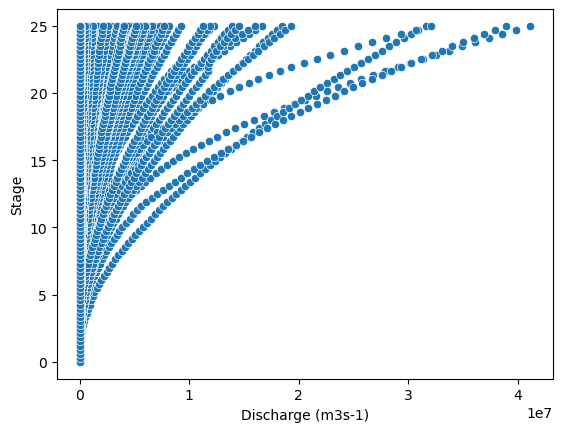

In [16]:
sns.scatterplot(data=src, x='Discharge (m3s-1)', y='Stage')

### estimate SRC as a power law and see how well it works for all catchments

In [17]:
first = src[src['CatchId'] == 166737678]

def f(x, a, b):
    return a*x**b

popt, pcov = curve_fit(f, first['Discharge (m3s-1)'], first['Stage'])

print('R2 =',r2_score(first['Stage'], f(first['Discharge (m3s-1)'], *popt)))

R2 = 0.9999072876914457


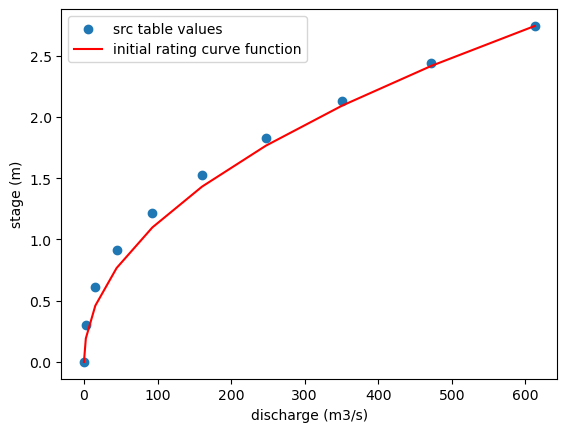

In [18]:
fig, ax = plt.subplots()

ax.scatter(first['Discharge (m3s-1)'][0:10], first['Stage'][0:10], label = 'src table values')
ax.plot(first['Discharge (m3s-1)'][0:10], f(first['Discharge (m3s-1)'][0:10], *popt), color = 'red', label = 'initial rating curve function')
# ax.plot(first['Discharge (m3s-1)'][0:10], f(first['Discharge (m3s-1)'][0:10], float(stgoptgdf[stgoptgdf['catchmask'] == 166737678]['src_a1_opt']), float(stgoptgdf[stgoptgdf['catchmask'] == 166737678]['src_b1'])),
#        color = 'green', label = 'adjusted rating curve function')
ax.set_xlabel('discharge (m3/s)')
ax.set_ylabel('stage (m)')
ax.legend()

### estimate SRC as a power law for every catchment row

In [19]:
def f(x,a,b):
    return a*x**b

for catchi in range(len(handflows['comid'])):
    catch = handflows['comid'][catchi]
    csrc = src[src['CatchId'] == catch]
    
    if not handflows['fema_disch_m3s'][catchi] > 0:
        handflows.loc[catchi,'src_a1'] = 0
        handflows.loc[catchi,'src_b1'] = 1
        handflows.loc[catchi,'maxstage_m'] = csrc['Stage'].max()
        handflows.loc[catchi,'src_R2_1'] = np.nan
        continue
    
    csrc['Discharge (m3s-1)'] = np.where(np.isnan(csrc['Discharge (m3s-1)']), 0, csrc['Discharge (m3s-1)'])
    popt1, pcov1 = curve_fit(f, csrc['Discharge (m3s-1)'], csrc['Stage'])
    handflows.loc[catchi,'src_a1'] = popt1[0]
    handflows.loc[catchi,'src_b1'] = popt1[1]
    handflows.loc[catchi,'maxstage_m'] = csrc['Stage'].max()
    src_R2_1 = r2_score(csrc['Stage'], f(csrc['Discharge (m3s-1)'], *popt1))
    handflows.loc[catchi,'src_R2_1'] = src_R2_1
    
    print(catch, ' R2 =', src_R2_1)
    

8777973  R2 = 0.9988454526667114
8777977  R2 = 0.9985551568011626
8778039  R2 = 0.999819735996442
8778063  R2 = 0.9995122293745453
8778067  R2 = 0.9996133485056848
8778073  R2 = 0.9994396707474222
8778075  R2 = 0.9993839582920218
8778091  R2 = 0.9985485257881007
8778139  R2 = 0.9998363220141079
8778145  R2 = 0.9995088741421791
8778189  R2 = 0.9998204569253111
8778231  R2 = 0.9996913368598547
8778239  R2 = 0.9993957080381956
8778245  R2 = 0.9996610056284746
8778251  R2 = 0.9991481178336059
8778519  R2 = 0.9999507044283741
8778535  R2 = 0.9997047305845149
8778549  R2 = 0.9971461064106794
8778555  R2 = 0.9966961361809094
8782321  R2 = 0.9992359889000437
8782331  R2 = 0.999416159918776
8782333  R2 = 0.9997317770423014
8782359  R2 = 0.9995640640974996
8782361  R2 = 0.9988460300320003
8782369  R2 = 0.9985163280423882
8782397  R2 = 0.9968791714351004
8782417  R2 = 0.9988937406611141
8782433  R2 = 0.9997653423433529
8782453  R2 = 0.9996805178287854
8782465  R2 = 0.9981128602109892
8782475  R2 

### use FEMA discharges and power law coefficients to calculate stages for each catchment

In [20]:
handflows['stage_m'] = handflows['src_a1']*handflows['fema_disch_m3s']**handflows['src_b1']
handflows['stage_m'] = np.where(handflows['stage_m'] > handflows['maxstage_m'], handflows['maxstage_m'], handflows['stage_m'])

### join the handflows dataframe to the catchments geodataframe to associate stages with catchments

In [21]:
handcatchmaskgdf = coicatchmask.merge(handflows, how = 'left', on = 'comid')
subset = handcatchmaskgdf[handcatchmaskgdf['stage_m'] > 0].reset_index()

<Axes: title={'center': 'Wake County 100-year HAND Stages (m)'}, xlabel='Longitude', ylabel='Latitude'>

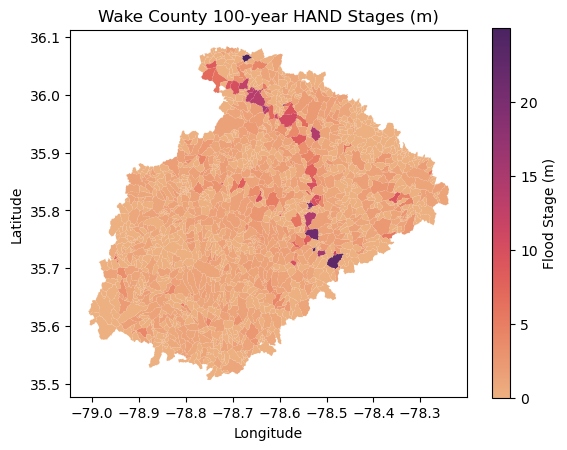

In [22]:
fig, ax = plt.subplots()

ax.set_title('Wake County 100-year HAND Stages (m)')

ax.set_xlabel('Longitude')

ax.set_ylabel('Latitude')

handcatchmaskgdf.plot(column = 'stage_m', 
                      legend = True, 
                      cmap = 'flare', 
                      legend_kwds={"label": "Flood Stage (m)"},
                      ax = ax)

In [23]:
subset['stage_opt_m'] = np.nan
subset

,index,comid,geometry,fema_disch_m3s,src_a1,src_a2,src_b1,src_b2,maxstage_m,src_R2_1,src_R2_2,stage_m,stage_opt_m
0,2,8783213,"MULTIPOLYGON (((-78.36616 35.85021, -78.36653 ...",162.793553,0.327811,0.0,0.541115,0.0,24.9936,0.999638,0.0,5.156721,NaN
1,3,8783109,"POLYGON ((-78.42850 35.86937, -78.42883 35.869...",30.299026,0.745011,0.0,0.302091,0.0,24.9936,0.999330,0.0,2.087799,NaN
2,5,8783119,"POLYGON ((-78.37960 35.86559, -78.37954 35.865...",152.344637,0.162613,0.0,0.444168,0.0,24.9936,0.998554,0.0,1.515987,NaN
3,11,8783311,"POLYGON ((-78.37184 35.83471, -78.37178 35.834...",281.186291,0.339724,0.0,0.385441,0.0,24.9936,0.999349,0.0,2.985866,NaN
4,16,8782987,"POLYGON ((-78.40044 35.88289, -78.40032 35.883...",144.415920,0.291690,0.0,0.422922,0.0,24.9936,0.999782,0.0,2.389301,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,1971,8842747,"POLYGON ((-78.93231 35.59333, -78.93225 35.593...",99.477084,0.218608,0.0,0.434570,0.0,24.9936,0.997575,0.0,1.613675,NaN
756,1972,8842209,"POLYGON ((-78.92211 35.66837, -78.92193 35.669...",13.535453,0.374566,0.0,0.360618,0.0,24.9936,0.998293,0.0,0.958424,NaN
757,1973,8842745,"POLYGON ((-78.91346 35.58513, -78.91379 35.585...",158.064640,0.210927,0.0,0.483855,0.0,24.9936,0.999865,0.0,2.443708,NaN
758,1975,8842735,"POLYGON ((-78.93976 35.61892, -78.94009 35.618...",42.730122,0.360821,0.0,0.460995,0.0,24.9936,0.998183,0.0,2.037285,NaN


### iterate through all catchments with FEMA stage and optimize HAND stage to agree with FEMA map

In [24]:
out = []
for catchi in range(len(subset['comid'])):
    catch = subset['comid'][catchi]
    catchgdf = subset[subset['comid'] == catch]
    catchhand, catchtrans = rasterio.mask.mask(hand, catchgdf.geometry, crop=True)
    catchhand = np.where(catchhand < 0, np.nan, catchhand).squeeze()
    catchhand2 = np.where(np.isnan(catchhand), 0, catchhand)
    stg_init = float(catchgdf['stage_m'])    
    fldmap = np.where(catchhand <= stg_init, 1, 0).squeeze()
    femafldmapv = gpd.clip(femafld, catchgdf)
    if len(femafldmapv) == 0:
        print(catch, 'no fema')
        continue
    geom_value = ((geom,value) for geom, value in zip(femafldmapv.geometry, [1]*len(femafldmapv.geometry)))
    femafldmap = rasterio.features.rasterize(geom_value,
                                             out_shape= catchhand.shape,
                                             transform= catchtrans,
                                             all_touched= False,
                                             fill = 0,
                                             merge_alg= rasterio.enums.MergeAlg.replace,
                                             dtype= rasterio.uint8)
    if femafldmap.sum() == 0:
        print(catch, 'no fema')
        continue
    agree_init = agreeance(fldmap, femafldmap)    
    stgs = np.arange(0, catchhand2.max() + 0.025, 0.025)
    ags = []
    for stg in stgs:
        stg_fldmap = np.where(catchhand <= stg, 1, 0).squeeze()
        ag = agreeance(stg_fldmap, femafldmap)
        ag.append(stg)
        ags.append(ag)
    ags = pd.DataFrame(ags, columns= ['agreeance','wet1dry2','dry1wet2', 'stage (m)'])
    ags_opt = ags[ags['agreeance'] == np.max(ags['agreeance'])].reset_index()
    ags_opt = ags_opt['stage (m)']
    if len(ags_opt) != 1:
        stg_opt = float(ags_opt[0])
    else:
        stg_opt = float(ags_opt)
    agmax = ags['agreeance'].max()
    agree_opt = ags[ags['agreeance'] == agmax]
    print(catch, stg_init, agree_init[0], stg_opt, agmax)
    out.append([catch, stg_init, agree_init[0], stg_opt, agmax])

8783213 5.156720709884715 0.9941520467836257 3.8000000000000003 1.0
8783109 2.087798708972317 0.6898044484251381 1.3250000000000002 0.8123930811632769
8783119 1.5159871368340903 0.7427055702917772 2.9000000000000004 0.9886064855390009
8783311 2.9858656827919137 0.8864932287954383 3.6750000000000003 0.9548240238136929
8782987 2.3893008515482976 0.8119591889448534 3.25 0.9389607160616609
8783531 9.185273724737693 0.5133652503490923 3.9250000000000003 0.8883521202361782
8783201 2.1966339814805647 0.8520529016975917 3.475 0.9758566978193146
8783105 2.2151089443908867 0.9347826086956522 2.4000000000000004 0.955281207133059
8778075 1.002247386073195 0.5039867109634552 3.4250000000000003 0.9232696523645475
8778067 1.0592216619398742 0.5612774451097804 2.325 0.9192452830188679
933020051 1.2131788506325283 0.5485880398671097 3.725 0.8488372093023255
8778039 0.7547668269826429 0.552317880794702 2.85 0.9523195876288659
933020045 10.313982010623093 1.0 1.05 1.0
8782545 2.0806186652901952 0.7780120

In [33]:
catch = 8784365
catchgdf = subset[subset['comid'] == catch]
catchhand, catchtrans = rasterio.mask.mask(hand, catchgdf.geometry, crop=True)
catchhand = np.where(catchhand < 0, np.nan, catchhand).squeeze()
catchhand2 = np.where(np.isnan(catchhand), 0, catchhand)
stg_init = float(catchgdf['stage_m'])    
fldmap = np.where(catchhand <= stg_init, 1, 0).squeeze()
femafldmapv = gpd.clip(femafld, catchgdf)
geom_value = ((geom,value) for geom, value in zip(femafldmapv.geometry, [1]*len(femafldmapv.geometry)))
femafldmap = rasterio.features.rasterize(geom_value,
                                         out_shape= catchhand.shape,
                                         transform= catchtrans,
                                         all_touched= False,
                                         fill = 0,
                                         merge_alg= rasterio.enums.MergeAlg.replace,
                                         dtype= rasterio.uint8)


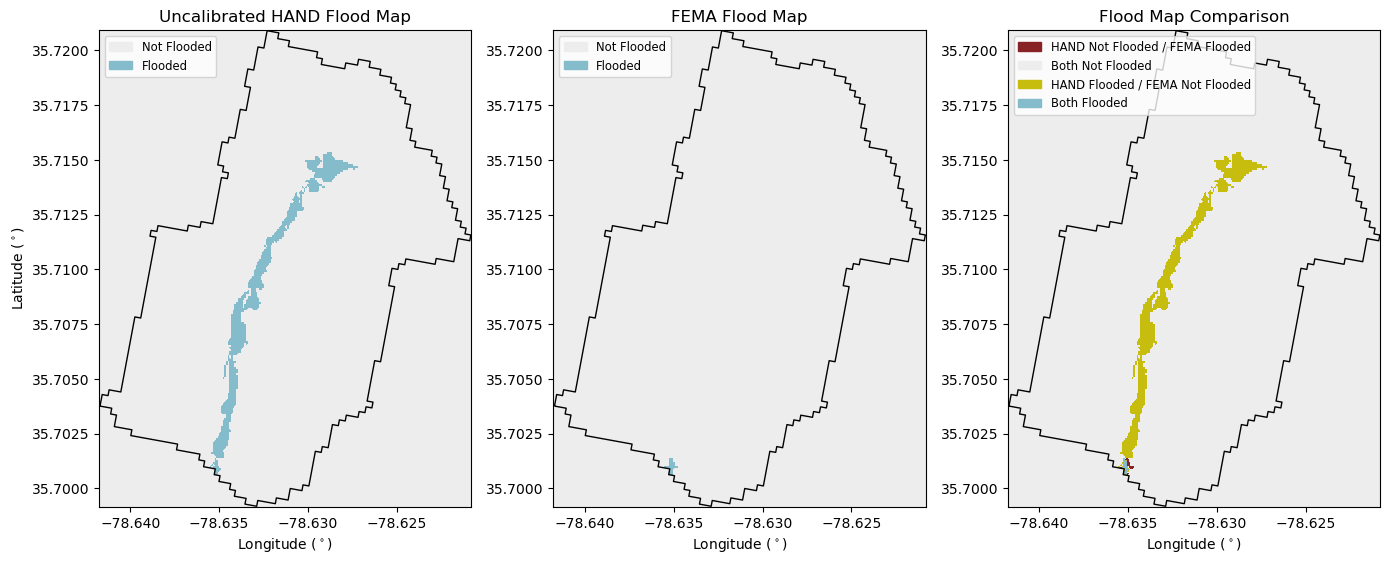

In [32]:
def raster_legend(raster,labels,colmap):
    values = np.unique(raster)
    fig = plt.figure()
    im = plt.imshow(comp, cmap= colmap)
    colors = [im.cmap(im.norm(value)) for value in values]
    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values))]
    plt.close(fig)
    return(patches)

cmap1 = colors.ListedColormap(['#ededed','#84bccb'])
cmap2 = colors.ListedColormap(['#872325','#ededed','#C7BD0E','#84bccb'])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (14,6))
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,6))


add = fldmap + femafldmap
add = np.where(add == 1, 0, add)
sub = fldmap - femafldmap
comp = add + sub

rasterio.plot.show(fldmap, ax = ax1, transform= catchtrans, cmap = cmap1)
catchgdf.plot(ax = ax1, facecolor = 'none', edgecolor = 'k')
rasterio.plot.show(femafldmap, ax = ax2, transform = catchtrans, cmap = cmap1)
catchgdf.plot(ax = ax2, facecolor = 'none', edgecolor = 'k')
rasterio.plot.show(comp, ax = ax3, transform = catchtrans, cmap = cmap2)
catchgdf.plot(ax = ax3, facecolor = 'none', edgecolor = 'k')

ax1.set_title('Uncalibrated HAND Flood Map')
ax1.set_ylabel('Latitude ($^\circ$)')
ax1.set_xlabel('Longitude ($^\circ$)')
ax1.legend(handles = raster_legend(fldmap, ['Not Flooded', 'Flooded'], cmap1), loc = 'upper left', fontsize = 'small')
ax2.set_title('FEMA Flood Map')
ax2.set_xlabel('Longitude ($^\circ$)')
ax2.legend(handles = raster_legend(femafldmap, ['Not Flooded', 'Flooded'], cmap1), loc = 'upper left', fontsize = 'small')
ax3.set_xlabel('Longitude ($^\circ$)')
ax3.set_title('Flood Map Comparison')
ax3.legend(handles = raster_legend(comp, ['HAND Not Flooded / FEMA Flooded', 'Both Not Flooded', 'HAND Flooded / FEMA Not Flooded', 'Both Flooded'], cmap2), 
           loc = 'upper left', fontsize = 'small')

fig.tight_layout()

# plt.rcParams['savefig.dpi']=450
# plt.savefig('HAND_FEMA_comparison_8784365.tif')

### show the results from the optimization

In [36]:
out = pd.DataFrame(out, columns= ['catchmask', 'stg_init_m', 'agree_init', 'stg_opt_m', 'agree_opt'])
out['% improvement'] = (out.agree_opt - out.agree_init)*100
out

,catchmask,stg_init_m,agree_init,stg_opt_m,agree_opt,% improvement
0,8783213,5.156721,0.994152,3.800,1.000000,0.584795
1,8783109,2.087799,0.689804,1.325,0.812393,12.258863
2,8783119,1.515987,0.742706,2.900,0.988606,24.590092
3,8783311,2.985866,0.886493,3.675,0.954824,6.833080
4,8782987,2.389301,0.811959,3.250,0.938961,12.700153
...,...,...,...,...,...,...
702,8842747,1.613675,0.742927,3.900,0.879131,13.620351
703,8842209,0.958424,0.020080,1.325,0.022665,0.258451
704,8842745,2.443708,0.819277,3.100,0.828235,0.895819
705,8842735,2.037285,0.811763,4.300,0.919490,10.772720


### initial agreeance

In [27]:
out['agree_init'].mean()

0.5721453527683146

### optimal agreeance

In [28]:
out['agree_opt'].mean()

0.72709801523809

### join optimal output to handcatchmaskgdf

In [29]:
stgoptgdf = handcatchmaskgdf.drop('stage_m', axis = 'columns').merge(out, how = 'right', left_on = 'comid', right_on = 'catchmask')
stgoptgdf['stg_opt_m'] = np.where(np.isnan(stgoptgdf['stg_opt_m']), 0, stgoptgdf['stg_opt_m'])
stgoptgdf

,comid,geometry,fema_disch_m3s,src_a1,src_a2,src_b1,src_b2,maxstage_m,src_R2_1,src_R2_2,catchmask,stg_init_m,agree_init,stg_opt_m,agree_opt,% improvement
0,8783213,"MULTIPOLYGON (((-78.36616 35.85021, -78.36653 ...",162.793553,0.327811,0.0,0.541115,0.0,24.9936,0.999638,0.0,8783213,5.156721,0.994152,3.800,1.000000,0.584795
1,8783109,"POLYGON ((-78.42850 35.86937, -78.42883 35.869...",30.299026,0.745011,0.0,0.302091,0.0,24.9936,0.999330,0.0,8783109,2.087799,0.689804,1.325,0.812393,12.258863
2,8783119,"POLYGON ((-78.37960 35.86559, -78.37954 35.865...",152.344637,0.162613,0.0,0.444168,0.0,24.9936,0.998554,0.0,8783119,1.515987,0.742706,2.900,0.988606,24.590092
3,8783311,"POLYGON ((-78.37184 35.83471, -78.37178 35.834...",281.186291,0.339724,0.0,0.385441,0.0,24.9936,0.999349,0.0,8783311,2.985866,0.886493,3.675,0.954824,6.833080
4,8782987,"POLYGON ((-78.40044 35.88289, -78.40032 35.883...",144.415920,0.291690,0.0,0.422922,0.0,24.9936,0.999782,0.0,8782987,2.389301,0.811959,3.250,0.938961,12.700153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,8842747,"POLYGON ((-78.93231 35.59333, -78.93225 35.593...",99.477084,0.218608,0.0,0.434570,0.0,24.9936,0.997575,0.0,8842747,1.613675,0.742927,3.900,0.879131,13.620351
703,8842209,"POLYGON ((-78.92211 35.66837, -78.92193 35.669...",13.535453,0.374566,0.0,0.360618,0.0,24.9936,0.998293,0.0,8842209,0.958424,0.020080,1.325,0.022665,0.258451
704,8842745,"POLYGON ((-78.91346 35.58513, -78.91379 35.585...",158.064640,0.210927,0.0,0.483855,0.0,24.9936,0.999865,0.0,8842745,2.443708,0.819277,3.100,0.828235,0.895819
705,8842735,"POLYGON ((-78.93976 35.61892, -78.94009 35.618...",42.730122,0.360821,0.0,0.460995,0.0,24.9936,0.998183,0.0,8842735,2.037285,0.811763,4.300,0.919490,10.772720


### create power law relationship needed to calculate optimal manning's n

In [30]:
for catchi in range(len(stgoptgdf['catchmask'])):
    if stgoptgdf['fema_disch_m3s'][catchi] == 0.0:
        continue
    catch = stgoptgdf['catchmask'][catchi]
    csrc = src[src['CatchId'] == catch]
    stgsneed = csrc[csrc['Stage'] < (float(stgoptgdf[stgoptgdf['catchmask']==catch]['stg_opt_m'])+2)]
    popt, pcov = curve_fit(f, stgsneed['Stage'],(stgsneed['WetArea (m2)']*stgsneed['HydraulicRadius (m)']**(2/3)))
    stgoptgdf.loc[catchi,'src_a2'] = popt[0]
    stgoptgdf.loc[catchi,'src_b2'] = popt[1]
    r2_2 = r2_score((stgsneed['WetArea (m2)']*stgsneed['HydraulicRadius (m)']**(2/3)), f(stgsneed['Stage'], *popt))
    stgoptgdf.loc[catchi,'src_R2_2'] = r2_2
    print(catch, 'R2 =', r2_2)
    

8783213 R2 = 0.9997386600963972
8783109 R2 = 0.9999860801132281
8783119 R2 = 0.9994490209088238
8783311 R2 = 0.9996855657893721
8782987 R2 = 0.9998099614143627
8783531 R2 = 0.9999890366288271
8783201 R2 = 0.9999044038044251
8783105 R2 = 0.9998564439422948
8778075 R2 = 0.9994163521734024
8778067 R2 = 0.9995450729334455
933020051 R2 = 0.9999982917264363
8778039 R2 = 0.9997004198166574
933020045 R2 = 0.9996386032814694
8782545 R2 = 0.9991681260696397
8782627 R2 = 0.9989654040926417
8777977 R2 = 0.9999117677540355
8782891 R2 = 0.9999754141650673
8782493 R2 = 0.999490077798849
8782685 R2 = 0.9999169799059053
8782417 R2 = 0.9997805347261653
8778251 R2 = 0.9999270471492031
8782577 R2 = 0.9998770633467076
8782749 R2 = 0.9999174971826097
933020037 R2 = 0.9999897043285499
8785895 R2 = 0.9999688014990818
8778073 R2 = 0.9998094542510783
8782331 R2 = 0.9998707223524075
8782683 R2 = 0.9996651480997968
8782739 R2 = 0.9999796324837756
933020052 R2 = 0.9999717036994097
8782369 R2 = 0.9997953778507088
8

### calculate optimal manning's n value for each catchment

In [31]:
stgoptgdf['mannings_n_opt_wake'] = (stgoptgdf['src_a2']*stgoptgdf['stg_opt_m']**stgoptgdf['src_b2'])/(stgoptgdf['src_a2']*stgoptgdf['stg_init_m']**stgoptgdf['src_b2'])*0.05
stgoptgdf['mannings_n_opt_wake'] = np.where(np.isnan(stgoptgdf['mannings_n_opt_wake']), 0.05, stgoptgdf['mannings_n_opt_wake'])
stgoptgdf.head()

,comid,geometry,fema_disch_m3s,src_a1,src_a2,src_b1,src_b2,maxstage_m,src_R2_1,src_R2_2,catchmask,stg_init_m,agree_init,stg_opt_m,agree_opt,% improvement,mannings_n_opt_wake
0,8783213,"MULTIPOLYGON (((-78.36616 35.85021, -78.36653 ...",162.793553,0.327811,76.642795,0.541115,2.117911,24.9936,0.999638,0.999739,8783213,5.156721,0.994152,3.800,1.000000,0.584795,0.026191
1,8783109,"POLYGON ((-78.42850 35.86937, -78.42883 35.869...",30.299026,0.745011,4.761780,0.302091,2.733748,24.9936,0.999330,0.999986,8783109,2.087799,0.689804,1.325,0.812393,12.258863,0.014425
2,8783119,"POLYGON ((-78.37960 35.86559, -78.37954 35.865...",152.344637,0.162613,95.587817,0.444168,2.347065,24.9936,0.998554,0.999449,8783119,1.515987,0.742706,2.900,0.988606,24.590092,0.229163
3,8783311,"POLYGON ((-78.37184 35.83471, -78.37178 35.834...",281.186291,0.339724,43.492422,0.385441,2.392687,24.9936,0.999349,0.999686,8783311,2.985866,0.886493,3.675,0.954824,6.833080,0.082179
4,8782987,"POLYGON ((-78.40044 35.88289, -78.40032 35.883...",144.415920,0.291690,64.984734,0.422922,2.208255,24.9936,0.999782,0.999810,8782987,2.389301,0.811959,3.250,0.938961,12.700153,0.098633


### look at the average increase in manning's n values throughout the county

In [32]:
stgoptgdf['mannings_n_opt_wake'].mean()/0.05

6.634301686488516

### adjust stage discharge power law $a$ coefficient for new discharges

In [40]:
stgoptgdf['scale_factor_wake'] = (stgoptgdf['mannings_n_opt_wake']/0.05)**stgoptgdf['src_b1']
stgoptgdf['src_a1_opt'] = stgoptgdf['src_a1']*stgoptgdf['scale_factor_wake']
# stgoptgdf.drop('geometry', axis = 1).to_csv('wake_final_output.csv')
stgoptgdf.head()

,comid,geometry,fema_disch_m3s,src_a1,src_a2,src_b1,src_b2,maxstage_m,src_R2_1,src_R2_2,catchmask,stg_init_m,agree_init,stg_opt_m,agree_opt,% improvement,mannings_n_opt_wake,scale_factor_wake,src_a1_opt
0,8783213,"MULTIPOLYGON (((-78.36616 35.85021, -78.36653 ...",162.793553,0.327811,76.642795,0.541115,2.117911,24.9936,0.999638,0.999739,8783213,5.156721,0.994152,3.800,1.000000,0.584795,0.026191,0.704770,0.231031
1,8783109,"POLYGON ((-78.42850 35.86937, -78.42883 35.869...",30.299026,0.745011,4.761780,0.302091,2.733748,24.9936,0.999330,0.999986,8783109,2.087799,0.689804,1.325,0.812393,12.258863,0.014425,0.686940,0.511778
2,8783119,"POLYGON ((-78.37960 35.86559, -78.37954 35.865...",152.344637,0.162613,95.587817,0.444168,2.347065,24.9936,0.998554,0.999449,8783119,1.515987,0.742706,2.900,0.988606,24.590092,0.229163,1.966401,0.319762
3,8783311,"POLYGON ((-78.37184 35.83471, -78.37178 35.834...",281.186291,0.339724,43.492422,0.385441,2.392687,24.9936,0.999349,0.999686,8783311,2.985866,0.886493,3.675,0.954824,6.833080,0.082179,1.211084,0.411434
4,8782987,"POLYGON ((-78.40044 35.88289, -78.40032 35.883...",144.415920,0.291690,64.984734,0.422922,2.208255,24.9936,0.999782,0.999810,8782987,2.389301,0.811959,3.250,0.938961,12.700153,0.098633,1.332857,0.388781


### show a map of the scale factors

<Axes: xlabel='Longitude ($^\\circ$)', ylabel='Latitude ($^\\circ$)'>

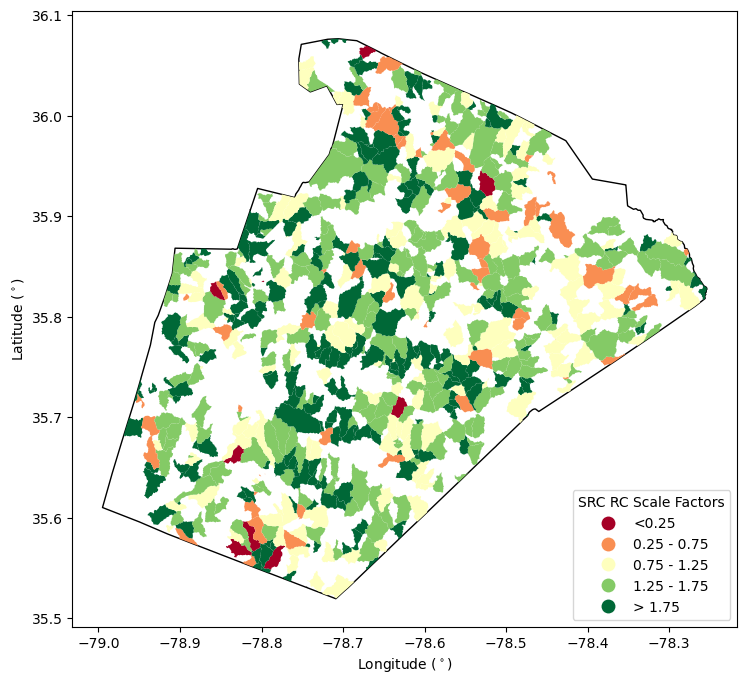

In [39]:
fig, ax = plt.subplots(figsize = (10,8))

ax.set_xlabel('Longitude ($^\circ$)')

ax.set_ylabel('Latitude ($^\circ$)')

coi.plot(ax = ax,
         facecolor = 'None')

stgoptgdfclip = gpd.clip(stgoptgdf, coi)

bins = [0.25, 0.75, 1.25, 1.75]

stgoptgdfclip.plot(column = 'scale_factor_wake', 
               legend = True, 
               cmap = 'RdYlGn', 
               legend_kwds={"loc": "lower right",
                            "title": "SRC RC Scale Factors",
                            "labels": ["<0.25", "0.25 - 0.75", "0.75 - 1.25", "1.25 - 1.75", "> 1.75"]},
               ax = ax,
               scheme='UserDefined', 
               classification_kwds={'bins': bins})

# plt.rcParams['savefig.dpi']=450
# plt.savefig('scale_factors.tif')